## Advanced Lane Finding Project



In [1]:
from io import BytesIO
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from multiprocessing import Pool
import dill as pickle
from functools import partial

In [2]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    #vmax = 255 if arr.dtype == 'uint8' else 1.0
    vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

In [3]:
def find_chessboard_corners(glob_regex='Calibration/calibration*.jpg'):
    object_p = np.zeros((6*9,3), np.float32)
    object_p[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = [] 
    chessboards = [] 
    
    images = glob.glob(glob_regex)

    for index, frame in enumerate(images):
        color_img = cv2.imread(frame)
        gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(object_p)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(color_img, (9,6), corners, ret)
            chessboards.append(color_img)
        
    plt.figure(figsize=(15, 15))
    for i in range(0, len(chessboards)):
        plt.subplot(5, 4, i+1)
        plt.imshow(chessboards[i])
        plt.axis('off')
    plt.show()
    return objpoints, imgpoints, chessboards

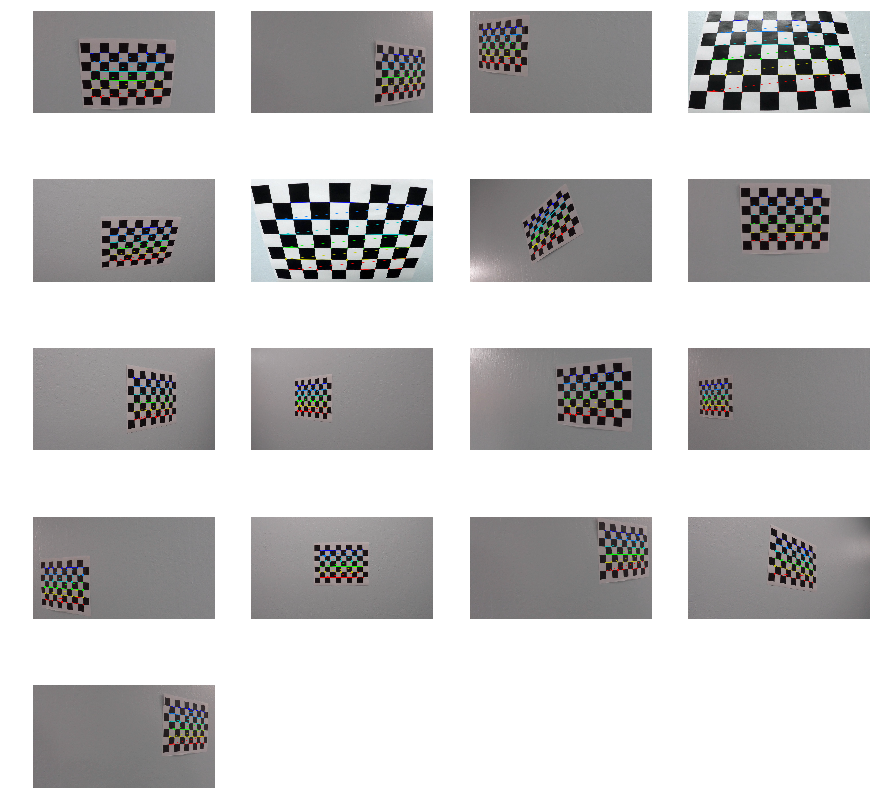

In [4]:
objpoints, imgpoints, chessboards = find_chessboard_corners()

In [5]:
def camera_calibrate(objpoints, imgpoint, img):
    img_size = img.shape[0:2]

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return ret, mtx, dist, dst

In [6]:
def undistort_image(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

NameError: name 'mtx' is not defined

In [ ]:
def load_test_images(glob_regex='test_images/*.jpg'):
    images=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images

def load_test_video(file_name='project_video_short.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images


In [ ]:
images = load_test_images()
def undistort_test(images=fixed(images), i:(0,len(images)-1)=0):
    file,img=images[i]
    undst=undistort_image(img)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title(file, fontsize=30)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
def binary_filter_road_pavement(img):
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    width=img.shape[1]
    height=img.shape[0]
    x_center=np.int(width/2)
    roi_width=100
    roi_height=200
    x_left=x_center-np.int(roi_width/2)
    x_right=x_center+np.int(roi_width/2)
    y_top=height-30
    y_bottom=y_top-roi_height
    y_bottom_small=y_top-np.int(roi_height/2)
    x_offset=50
    x_finish=width-x_offset
    
    roi_center=img[y_bottom:y_top, x_left:x_right]
    roi_left=img[y_bottom_small:y_top, x_offset:roi_width+x_offset]
    roi_right=img[y_bottom_small:y_top, x_finish-roi_width:x_finish]
    roi=np.hstack((roi_center,np.vstack((roi_left,roi_right))))
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    
    roihist = cv2.calcHist([roi_hsv],[0, 1], None, [256, 256], [0, 256, 0, 256] )
    cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
    dst = cv2.calcBackProject([img_hsv],[0,1],roihist,[0,256,0,256],1)
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    cv2.filter2D(dst,-1,disc,dst)
    
    ret,thresh = cv2.threshold(dst,10,250,cv2.THRESH_BINARY_INV)

    return thresh

In [ ]:
def combined_threshold(img, kernel=3, grad_thresh=(30,100), mag_thresh=(70,100), dir_thresh=(0.8, 0.9),
                       s_thresh=(100,255), r_thresh=(150,255), u_thresh=(140,180),
#                       threshold="daytime-normal"):
    threshold="daytime-filter-pavement"):

    def binary_thresh(channel, thresh = (200, 255), on = 1):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = on

        return binary
    
    if threshold in ["daytime-bright","daytime-filter-pavement"]:
         r_thresh=(210,255)
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    gradx = binary_thresh(scaled_sobelx, grad_thresh)
    
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    grady = binary_thresh(scaled_sobely, grad_thresh)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = binary_thresh(gradmag, mag_thresh)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_thresh(absgraddir, dir_thresh)
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    sbinary = binary_thresh(S, s_thresh)
    
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    rbinary = binary_thresh(R, r_thresh)
    
    # YUV colour
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y = yuv[:,:,0]
    U = yuv[:,:,1]
    V = yuv[:,:,2]
    ubinary = binary_thresh(U, u_thresh)
    
    combined = np.zeros_like(dir_binary)
    
    if threshold == "daytime-normal": # default
        combined[(gradx == 1)  | (sbinary == 1) | (rbinary == 1) ] = 1
    elif threshold == "daytime-shadow":
        combined[((gradx == 1) & (grady == 1)) | (rbinary == 1)] = 1
    elif threshold == "daytime-bright":
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
    elif threshold == "daytime-filter-pavement":
        road_binary=binary_thresh(binary_filter_road_pavement(img))
        combined[(((gradx == 1)  | (sbinary == 1)) &(road_binary==1)) | (rbinary == 1 ) ] = 1
    else:
        combined[((gradx == 1) | (rbinary == 1)) & ( (sbinary ==1) | (ubinary ==1)| (rbinary == 1 ))] = 1
        
    return combined

In [ ]:
images = load_test_video(file_name='project_video_shadow.mp4')

In [ ]:
def combined_threshold_image(images=fixed(images), i:(0,len(images)-1)=94, 
                    sobel_kernel:(3,21,2)=3,
                    grad_min:(0,255)=30, grad_max:(0,255)=100,
                    mag_min:(0,255)=70, mag_max:(0,255)=100,
                    dir_min:(0.,np.pi/2)=0.8, dir_max:(0,np.pi/2)=0.9,
                  
                    s_min:(0,255)=100, s_max:(0,255)=255,
                    r_min:(0,255)=150, r_max:(0,255)=255,
                    u_min:(0,255)=140, u_max:(0,255)=180,
                    threshold:["daytime-normal","daytime-shadow","daytime-bright","daytime-filter-pavement","other"]="daytime-normal"):
  
    file,img=images[i]
    dir_binary=combined_threshold(img, sobel_kernel,
                                  grad_thresh=(grad_min, grad_max),
                                  mag_thresh=(mag_min, mag_max),
                                  dir_thresh=(dir_min, dir_max),
                                  s_thresh=(s_min, s_max),
                                  r_thresh=(r_min, r_max),
                                  u_thresh=(u_min, u_max),
                                  threshold=threshold
                                 )
    return arr2img(dir_binary)

In [ ]:
def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (0,0,255))

def perspective_transforms(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def perspective_warp(img, M):
    #img_size = (img.shape[1], img.shape[0])
    img_size = (img.shape[0], img.shape[1])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def perspective_unwarp(img, Minv):
    img_size = (img.shape[0], img.shape[1])
    
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped
    
def calc_warp_points(img_height,img_width,x_center_adj=0):
    
    imshape = (img_height, img_width)
    xcenter=imshape[1]/2+x_center_adj
    xfd=54
    yf=450
    xoffset=120
    
    src = np.float32(
        [(xoffset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]-xoffset,imshape[0])])
    
    
    dst = np.float32(
        [(xoffset,imshape[1]),
         (xoffset,0),
         (imshape[0]-xoffset, 0),
        (imshape[0]-xoffset,imshape[1])])
        
    return src, dst
    
def binary_topdown(img, threshold="daytime-normal"):
    # camera undistort
    undistorted=undistort_image(img)
    
    # top down view warp of the undistorted binary image
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])

    # calculate matrix for perspective warp
    M, _ = perspective_transforms(src, dst)
    
    
    def noise_detect(warped):
        histogram=np.sum(warped, axis = 1)
        return (histogram > 100).any()
        
    # use the default
    if threshold == "daytime-normal":
        # this works in normal daytime conditions
        combined=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(combined, M)
        if noise_detect(warped):
            combined=combined_threshold(undistorted, threshold="daytime-shadow")
            warped = perspective_warp(combined, M)
    else:
        undistorted=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(undistorted, M)
    
    return warped

In [ ]:
images = load_test_images()
#images = load_test_video()
# images = load_test_video(file_name='project_video_shadow.mp4')

@interact
def transform_test(images=fixed(images), i:(0,len(images)-1)=0, threshold_flag:(False,True)=False):
    file,img=images[i]
    undistorted=undistort_image(img)
    if threshold_flag:
        undistorted=combined_threshold(undistorted)
    #vertices=[(700,200), (700,1100), (400,700), (400,500)]
    
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])
    M, _ = perspective_transforms(src, dst)
    draw_lines(undistorted,src)
    
    warped = perspective_warp(undistorted, M)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undistorted, cmap="gray")
    ax1.set_title(file, fontsize=30)
    ax2.imshow(warped, cmap="gray")
    ax2.set_title('Undistorted & Warped Image', fontsize=30)
    

In [ ]:
from scipy import signal

def lane_histogram(img, height_start=800, height_end=1250):
    histogram = np.sum(img[int(height_start):int(height_end),:], axis=0)
    
    return histogram

def lane_peaks(histogram):
    peaks = signal.find_peaks_cwt(histogram, np.arange(1,150),min_length=150)
    
    midpoint = np.int(histogram.shape[0]/2)
    # if we found at least two peaks use the signal approach (better in shadows)
    if len(peaks) > 1:
        # in case more then 2 found just get the left and right one
        peak_left, *_, peak_right = peaks
        
    # otherwise just choose the highest points in left and right of center segments
    else:
       
        peak_left = np.argmax(histogram[:midpoint])
        peak_right = np.argmax(histogram[midpoint:]) + midpoint
    
    return peak_left, peak_right

class WindowBox(object):
    def __init__(self, binimg, x_center, y_top, width=100, height=80, mincount=50, lane_found=False):
        self.x_center = x_center
        self.y_top = y_top
        self.width = width
        self.height = height
        self.mincount = mincount
        self.lane_found = lane_found
        
        # derived
        self.x_left = self.x_center - int(self.width/2)
        self.x_right = self.x_center + int(self.width/2)
        self.y_bottom = self.y_top - self.height   
        self.imgwindow = binimg[self.y_bottom:self.y_top,
                                self.x_left:self.x_right]
        self.nonzeroy = self.imgwindow.nonzero()[0]
        self.nonzerox = self.imgwindow.nonzero()[1]
         
    def center(self):
        return (self.x_center, int(self.y_top-self.y_bottom)/2)
    
    def next_windowbox(self, binimg):
        if self.has_line():
            # recenter based on mean
            x_center = np.int(np.mean(self.nonzerox + self.x_left))
        else:
            # use existing center
            x_center = self.x_center
            
        # next box top starts at lasts bottom
        y_top = self.y_bottom 
        
        return WindowBox(binimg, x_center, y_top, 
                         width=self.width, height=self.height, mincount = self.mincount,
                         lane_found=self.lane_found)
    def _nonzerox_count(self):
        return len(self.nonzerox)
    
    def _is_noise(self):
        return self._nonzerox_count() > self.imgwindow.shape[0] * self.imgwindow.shape[1] *.75
        
    def has_line(self):
        return (self._nonzerox_count() > self.mincount) ^ self._is_noise()
    
    def has_lane(self):
        if not self.lane_found and self.has_line():
            self.lane_found = True
        return self.lane_found
        
    def __str__(self):
        return "WindowBox [%.3f, %.3f, %.3f, %.3f]" % (self.x_left,
                                                       self.y_bottom,
                                                       self.x_right,
                                                       self.y_top)



def find_lane_windows(window_box, binimg):
    boxes=[]

    # keep searching up the image for a lane line and append the boxes
    continue_lane_search = True
    contiguous_box_no_line_count = 0
    while (continue_lane_search and window_box.y_top >= 0):
        if window_box.has_line():
            boxes.append(window_box)

        window_box=window_box.next_windowbox(binimg)

        if window_box.has_lane():
            if window_box.has_line():
                contiguous_box_no_line_count = 0
            else:
                contiguous_box_no_line_count += 1
                
                if contiguous_box_no_line_count >= 4:
                    continue_lane_search = False

    return boxes
    
def calc_lane_windows(binimg, nwindows=12, width=100):
    
    # calc height of each window
    height = np.int(binimg.shape[0]/nwindows)
    
    # find left and right lane centers to start with
    peak_left, peak_right = lane_peaks(lane_histogram(binimg))

    
    # Initialise left and right window boxes
    ytop = binimg.shape[0]

    wbl = WindowBox(binimg, peak_left, ytop, width=width, height=height)
#     left_boxes = find_lane_windows(wbl, binimg)
    
    wbr = WindowBox(binimg, peak_right, ytop, width=width, height=height)
#     right_boxes = find_lane_windows(wbr, binimg)

    # paralleise the search
    find_lane_windows_binimg = partial(find_lane_windows, binimg=binimg)
    with Pool(2) as p:
        left_boxes, right_boxes = p.map(find_lane_windows_binimg, [wbl, wbr])

    return (left_boxes, right_boxes)



def calc_fit_from_boxes(boxes):
    if len(boxes) > 0:
        # flaten and adjust all boxes for the binary images
        xs = np.concatenate([b.nonzerox + b.x_left for b in boxes ])
        ys = np.concatenate([b.nonzeroy + b.y_bottom for b in boxes])
        
        # return the polynominal
        return np.polyfit(ys, xs, 2)
    else:
        return None
        
    

def poly_fitx(fity, line_fit):
    fit_linex = line_fit[0]*fity**2 + line_fit[1]*fity + line_fit[2]
    return fit_linex

def calc_lr_fit_from_polys(binimg, left_fit, right_fit, margin=100):
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    def window_lane(poly):
        return (
            (nonzerox > (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] - margin)) 
            & (nonzerox < (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] + margin))
        )
    
    def window_polyfit(lane_inds):
        xs = nonzerox[lane_inds]
        ys = nonzeroy[lane_inds]
       
        # return the polynominal
        return np.polyfit(ys, xs, 2)
    
    new_left_fit = left_fit
    if left_fit is not None: 
        new_left_fit = window_polyfit(window_lane(left_fit))
        
    new_right_fit =  right_fit
    if right_fit is not None: 
        new_right_fit = window_polyfit(window_lane(right_fit)) 
    
    return (new_left_fit, new_right_fit)

In [ ]:
images = load_test_video(file_name='project_video_short.mp4')

In [ ]:
import matplotlib.patches as patches

def topdown_histogram_test(images=fixed(images), i:(0,len(images)-1)=0):
    file,img=images[i]
    topdown_binary_img = binary_topdown(img)
    height=topdown_binary_img.shape[0]
    histogram = lane_histogram(topdown_binary_img)
    peak_left, peak_right = lane_peaks(histogram)

    boxes_left, boxes_right = calc_lane_windows(topdown_binary_img,width=150)

    left_fit = calc_fit_from_boxes(boxes_left)
    right_fit = calc_fit_from_boxes(boxes_right)
    
    # Generate x and y values for plotting
    fity = np.linspace(0, height-1, height)
    if left_fit is not None: 
        fit_leftx = poly_fitx(fity, left_fit)
    if right_fit is not None: 
        fit_rightx = poly_fitx(fity, right_fit)
    
    margin=100
    new_left_fit, new_right_fit = calc_lr_fit_from_polys(topdown_binary_img, left_fit, right_fit, margin)
    if new_left_fit is not None:
        new_leftx = poly_fitx(fity, new_left_fit)
    if new_right_fit is not None:    
        new_rightx = poly_fitx(fity, new_right_fit)
    
    f, ((ax3,ax4), (ax1, ax2)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.set_title("warped box seek")
    ax1.imshow(topdown_binary_img,cmap='gray')
    ax1.plot(height-histogram)
    ax1.plot((height,peak_left), (height,height-histogram[peak_left]), 'rx')
    ax1.plot((height,peak_right), (height,height-histogram[peak_right]), 'rx')
    for b in boxes_left + boxes_right:
        ax1.add_patch(patches.Rectangle((b.x_left, b.y_bottom),b.width,b.height,facecolor="none",edgecolor="green"))
    if left_fit is not None:
        ax1.plot(fit_leftx, fity, color='yellow')
    if right_fit is not None:
        ax1.plot(fit_rightx, fity, color='yellow')
    ax1.set_xlim(0, 720)
    ax1.set_ylim(1280, 0)
    
    ax2.set_title("warped new polyfit from box seek poly")
    ax2.imshow(topdown_binary_img,cmap='gray')
    ax2.set_xlim(0, 720)
    ax2.set_ylim(1280, 0)
    if new_left_fit is not None:
        ax2.plot(new_leftx, fity, color='yellow')
        ax2.fill_betweenx(fity, new_leftx-margin,new_leftx+margin,alpha=0.25,color='green')
    if left_fit is not None:    
        ax2.fill_betweenx(fity, fit_leftx-margin,fit_leftx+margin,alpha=0.5,color='blue')
    if new_right_fit is not None:
        ax2.plot(new_rightx, fity, color='yellow')
        ax2.fill_betweenx(fity, fit_rightx-margin,fit_rightx+margin,alpha=0.5,color='blue')
    if right_fit is not None:
        ax2.fill_betweenx(fity, new_rightx-margin,new_rightx+margin,alpha=0.25,color='green')
    
    ax3.set_title("original image")
    ax3.imshow(img)
    
    ax4.set_title("undistorred & combined threshold")
    ax4.imshow(combined_threshold(undistort_image(img)),cmap='gray')

In [ ]:
def calc_curvature(poly, height=1280):
    
    fity = np.linspace(0, height-1, num=height)
    y_eval = np.max(fity)
   
    lane_px_height=275 # manual observation 
    ym_per_pix = (3./lane_px_height) # meters per pixel in y dimension
    lane_px_width=413
    xm_per_pix = 3.7/lane_px_width
    
    def fit_in_m(poly):
        xs = poly_fitx(fity, poly)
        xs = xs[::-1] # Reverse to match top-to-bottom in y
        
        return np.polyfit(fity*ym_per_pix, xs*xm_per_pix, 2)
    
    if poly is None:
        return .0
    
    poly_cr = fit_in_m(poly)
    curveradm = ((1 + (2*poly_cr[0]*y_eval*ym_per_pix + poly_cr[1])**2)**1.5) / np.absolute(2*poly_cr[0])
    
    return curveradm

def fit_window(binimg, poly, margin=45):
    height = binimg.shape[0]
    y = binimg.shape[0]
   
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    fity = np.linspace(0, height-1, height)
    
    def window_lane(poly):
        return (
            (nonzerox > (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] - margin)) 
            & (nonzerox < (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] + margin))
        )
    
    def fit(lane_inds):
        xs = nonzerox[lane_inds]
        #xs = xs[::-1] # Reverse to match top-to-bottom in y
        
        return np.polyfit(fity, xs, 2)
    
    return fit(window_lane(poly))

In [ ]:
images = load_test_images()

@interact
def curvature_test(images=fixed(images), i:(0,len(images)-1)=0):
    file,img=images[i]
    binimg = binary_topdown(img)
    height = binimg.shape[0]
    histogram = lane_histogram(binimg,int(height/2),height)
    peak_left, peak_right = lane_peaks(histogram)
    
    # minimum distance between lanes is 3.7 meters
    lane_px_width=413
    xm_per_pix = 3.7/413 # meters per pixel in x dimension
    delta_x_pix = peak_right-peak_left
    delta_x_m = delta_x_pix * xm_per_pix
    print("left: %d, right %d - distance (%d pixel, %0.2f m) min 3.7 m" % (peak_left, peak_right, delta_x_pix, delta_x_m))
    
    # dashed lane lines are 10 feet or 3 meters long each
    lane_px_height=275 # manual observation
    ym_per_pix = (3./lane_px_height) # meters per pixel in y dimension
    delta_y_pix = lane_px_height 
    delta_y_m = delta_y_pix * ym_per_pix
    print("dashed lane line length (%d pixel, %0.2f m) should be 3 m" % (delta_y_pix, delta_y_m))
    
    boxes_left, boxes_right = calc_lane_windows(binimg)

    left_fit = calc_fit_from_boxes(boxes_left)
    right_fit = calc_fit_from_boxes(boxes_right)
    
    print(calc_curvature(left_fit), calc_curvature(right_fit))
    
    # return arr2img(binimg)
    fity = np.linspace(0, height-1, num=height)
    fitxl = poly_fitx(fity, left_fit)
    fitxr = poly_fitx(fity, right_fit)
    
    f, (ax1) = plt.subplots(1, 1)
    ax1.imshow(binimg,cmap='gray')
    ax1.plot(fitxl, fity, color='yellow')
    ax1.plot(fitxr, fity, color='yellow')
    ax1.set_xlim(0,720)
    ax1.set_ylim(1280,0)

In [ ]:
from collections import deque

# holds current line details
class Line():
    """Line Class"""
    LINE_FIT_INVALID_MSG = "Line has an invalid polynominal." 
    def __init__(self, ploty, poly_fit, binimg):
        self.__ploty = ploty
        self.__poly_fit = poly_fit
        self.__binimg = binimg
        
        # derived
        self.__curvature = None
        self.__y_bottom = np.min(ploty)
        self.__y_top = np.max(ploty)
        
        try:
            self.__x_bottom = poly_fitx(self.__y_bottom, self.poly_fit)
            self.__x_top = poly_fitx(self.__y_top, self.poly_fit)
        except TypeError:
            raise ValueError(Line.LINE_FIT_INVALID_MSG)
                
        
    @property
    def xs(self):
        return poly_fitx(self.ploty, self.poly_fit)
    
    @property
    def ploty(self):
        return self.__ploty
    
    @property
    def poly_fit(self):
        return self.__poly_fit
    
    @property
    def binimg(self):
        return self.__binimg
    
    @property
    def y_bottom(self):
        return self.__y_bottom
    
    @property
    def y_top(self):
        return self.__binimg.shape[1]
    
    @property
    def x_bottom(self):
        return self.__x_bottom

    @property
    def x_top(self):
        return self.__x_top
    
    @property
    def curvature(self):
        if self.__curvature is None:
            self.__curvature = calc_curvature(self.poly_fit)
        return self.__curvature
    
    def __str__(self):
        return "Line(%.3f, %s, bot:(%d,%d) top:(%d,%d))" % (self.curvature,
                                                            self.poly_fit,
                                                            self.x_bottom, self.y_bottom,
                                                            self.x_top, self.y_top)
                                                       
    
# contains the Line details and methods to determine current road line
class RoadLine():
    """RoadLine Class"""
    LINE_ISNT_SANE_MSG = "Line didn't pass sanity checks." 
    
    def __init__(self, line, line_history_max=6):
        # initialise class
        self.__line_history = deque([])
                
        self.__all_curvatures = None
        
        # assign constructor variables
        self.line_history_max = line_history_max
        self.line = line # must have at 
    
    def __str__(self):
        return "RoadLine(%s, mean_fit=%s, mean_curvature=%.3f, history=[%s])" % (self.line,  
                                                              self.mean_fit,
                                                              self.mean_curvature,                    
                                                              ', '.join([str(l.curvature) for l in self.__line_history]))
    @property
    def line(self):
        if len(self.__line_history) > 0:
            return self.__line_history[-1]
        else:
            return None
    
    @line.setter
    def line(self, line):
        
        def xs_are_near(x1,x2, limit=100):
            return np.abs(x1-x2) < limit
        
        def is_line_sane(line):
            try:
                line_prev = self.line
                
                # top is near car
                if not xs_are_near(line.x_top,line_prev.x_top):
                    raise ValueError("top xs weren't near")
                
                # bottom is horizon
                if not xs_are_near(line.x_bottom,line_prev.x_bottom):
                    raise ValueError("bottom xs weren't near")
                
            # if line doesnt cross at y_bottom isnt an ellipse which should through a ValueError
            except ValueError as err:
                print("value error: {0}".format(err))
                return False
            
            return True
            
        if len(self.__line_history) > 0 and not is_line_sane(line):
            raise ValueError(self.LINE_ISNT_SANE_MSG)
            
        self._queue_to_history(line)
        
            
        
    def _queue_to_history(self, line):
        self.__line_history.append(line)
        self.__all_curvatures = None # will get recreated lazily
        # only keep the last lines appended
        if self.line_history_count > self.line_history_max:
            self.__line_history.popleft()
        
    @property
    def line_history_count(self):
        return len(self.__line_history) 
    
    @property
    def curvature(self):
        return self.line.curvature
    
    @property
    def curvatures(self):
        if self.__all_curvatures is None:
            self.__all_curvatures = np.array([line.curvature for line in self.__line_history])
        return self.__all_curvatures
    
    @property
    def mean_curvature(self):
        return np.mean(self.curvatures)
    
    @property
    def std_curvature(self):
        return np.std(self.curvatures)
    
    @property
    def max_abs_curvature_variance(self):
        return np.max(np.abs(self.curvatures-np.mean(self.curvatures)))
    
    @property
    def line_fits(self):
        return np.array([line.poly_fit for line in self.__line_history])
    
    @property
    def mean_fit(self):
        lf=self.line_fits
        nweights=len(lf)
        
        weights = None
        # if just one no need for weights
        if nweights > 1:
            # if two then give more weight to the newer
            if nweights == 2:
                weights = [.60,.40]
            # otherwise start with two and pad out evenly the remainder
            else:
                weights = [.40,.30]

                # pad out the weights 
                if nweights > len(weights):
                    weights=np.pad(weights,(0,nweights-len(weights)),'constant', 
                             constant_values=(1-np.sum(weights))/(nweights-len(weights)))
            
            
        return np.average(lf, weights=weights, axis=0)
       
    @property
    def ploty(self):
        # will all have same ploty
        return self.line.ploty
    
    @property
    def mean_xs(self):
        return poly_fitx(self.ploty, self.mean_fit)
            

    
# contains the left & right road lines and associated image 
class Lane():
    """Lane Class"""
    lane_px_width=413
    xm_per_pix = 3.7/lane_px_width # meters per pixel in x dimension - copied from calc_curvature for convenience

    THRESHOLD_DAYTIME_NORMAL = "daytime-normal"
    THRESHOLD_DAYTIME_SHADOW = "daytime-shadow"
    THRESHOLD_DAYTIME_BRIGHT = "daytime-bright"
    THRESHOLD_DAYTIME_FILTER = "daytime-filter-pavement"
    THRESHOLD_WINDOWING = "windowing"
    
    def __init__(self, img_height, img_width, mtx, dist):
        self.__img_height = img_height
        self.__img_width = img_width
        
        # camera callibration
        self.__mtx = mtx
        self.__dist = dist

        # set images to None
        self.__image = None 
        self.__undistorted_image = None
        self.__binary_image = None
        self.__warped = None
        self.__warped_threshold = self.THRESHOLD_DAYTIME_NORMAL

        # warp points and transformation matrices
        warp_src, warp_dst = calc_warp_points(img_height, img_width)
        self.__warp_src = warp_src
        self.__warp_dst = warp_dst
        M, Minv = perspective_transforms(warp_src, warp_dst)
        self.__M = M
        self.__Minv = Minv
        
        # arrays for plotting
        #self.__ploty = np.linspace(0,img_height-1, img_height)
        # warped image has been rotated by 90% to give longer lines
        warped_height=img_width
        self.__ploty = np.linspace(0,warped_height-1, warped_height)
        self.__pts_zero = np.zeros((1,warped_height,2),dtype=np.int)
        
        # place holders for the road lines - cant initialise until we have a camera image
        self.__road_line_left = None
        self.__road_line_right = None
           
    @property
    def img_height(self):
        return self.__img_height
    @property
    def img_width(self):
        return self.__img_width  
    
    @property
    def pts_zero(self):
        return self.__pts_zero
    
    @property 
    def ploty(self):
        return self.__ploty

    @property
    def undistorted_image(self):
        return self.__undistorted_image
        
    @property
    def binary_image(self):
        return self.__binary_image
    
    @property
    def warped(self):
        return self.__warped
    
    @property
    def warped_threshold(self):
        return self.__warped_threshold
    
    @property
    def warped_decorated(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        warp_ff=np.array(self.warped * 255).astype(np.uint8)
        warp_colour = np.dstack((warp_zero, warp_zero, warp_zero))
        img_warp= np.dstack((warp_ff, warp_ff, warp_ff)).astype(np.uint8)
        
        ploty = self.ploty
        
        width=self.warped.shape[1]
        height=self.warped.shape[0]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.road_line_left.line.xs, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.road_line_right.line.xs, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_colour, np.int_([pts]), (0, 255, 0))
        
        # draw the lane histogram
        histogram = self.warped_histogram
        hist_pts=[[i, height-histogram[i]] for i in range(0,width -1)]
   
        cv2.polylines(img_warp,np.int_([hist_pts]), False, (0,0,255))
       
        
        
        result = cv2.addWeighted(img_warp, .7,warp_colour, 0.3, 0)
        result = cv2.putText(result,'%s' % self.warped_threshold, (5, 20), font, .5,(255,255,255),1,cv2.LINE_AA)
        
        # create the right side
        binimg_ff = np.array(self.binary_image * 255).astype(np.uint8)
        binimg_ff_color = np.dstack((binimg_ff, binimg_ff, binimg_ff))
       
        rhs = np.vstack((self.undistorted_image, binimg_ff_color, self.result_decorated))
        rhs = cv2.resize(rhs, (result.shape[1],result.shape[0]))
        result = np.hstack((result,rhs))
        
        return result
    
    @property
    def road_line_left(self):
        return self.__road_line_left
   
    @property
    def road_line_right(self):
        return self.__road_line_right
    
    @property
    def result(self):
        result = self._draw_lanes_unwarped()
        return result
    
    @property
    def result_decorated(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        rll, rlr = self.road_line_left, self.road_line_right
        cl, clm = rll.curvature, rll.mean_curvature
        cr, crm = rlr.curvature, rlr.mean_curvature
        xcoffset = self.x_center_offset
        
        result = self.result
        result = cv2.putText(result,'%0.2f,%0.2f' % (cl,clm), (5,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(result,'%0.2f,%0.2f' % (cr,crm), (1000,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(result,'%.3f' % xcoffset, (640, 700), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        return result
    
    @property
    def image(self):
        return self.__image
    
    def _image_yuv_equalize(self, image): 
        yuv=cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))
        yuv[0]=cv2.equalizeHist(yuv[0])
        return cv2.cvtColor(cv2.merge(yuv), cv2.COLOR_YUV2RGB)

    @image.setter
    def image(self, image):
        # make sure its a bgr image being passed in
        self.__image = image
        undistorted = undistort_image(self.__image, self.__mtx, self.__dist)
        self.__undistorted_image = undistorted
           
        # look for a warp that isnt too noisy 
        self.__binary_image, self.__warped, self.__warped_threshold = self._undistort_warp_search(undistorted)
        
        # first time start with a full search to prime left & right road line objects
        if self.road_line_left is None and self.road_line_right is None:
            self._full_histogram_lane_search()
        
        # left & right recalc using previous polynominal fit
        else:
            self._recalc_road_lines_from_polyfit()
    
    def _undistort_warp_search(self, undistorted):
        # intitial threshold
        threshold = self.THRESHOLD_DAYTIME_NORMAL
        binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, threshold)
        
        # while we keep finding a warp (only interested near the road lines) with noise
        tried_daytime_shadow = False
        tried_daytime_bright = False
        tried_window_shadowing = False
        tried_daytime_pavement_filter = False
        noise_level = 100
        
        while self._warped_has_noise(warped, noise_level=noise_level): 
            
            if not tried_daytime_bright:
                binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, 
                                                                                   self.THRESHOLD_DAYTIME_BRIGHT)
                tried_daytime_bright = True
                continue
            
            if not tried_daytime_shadow:
                binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, 
                                                                                   self.THRESHOLD_DAYTIME_SHADOW)
                tried_daytime_shadow = True
                # should be less noise for the next shadow check
                noise_level = 75
                continue
             
            if not tried_daytime_pavement_filter: 
                binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, 
                                                                                   self.THRESHOLD_DAYTIME_FILTER)
                tried_daytime_pavement_filter = True
                continue
            
            if not tried_window_shadowing: 
                thresholds=[Lane.THRESHOLD_DAYTIME_NORMAL, Lane.THRESHOLD_DAYTIME_BRIGHT,
                            Lane.THRESHOLD_DAYTIME_SHADOW, Lane.THRESHOLD_DAYTIME_FILTER]
                binary_image, warped, threshold = self._warped_window_thresholding(undistorted, thresholds=thresholds)

                tried_window_shadowing = True
                continue
              
            # window shadowing is the most expensive and best that could be done
            # nothing left to try so break out  
            break
            
        return (binary_image, warped, threshold)
    
    def _warped_window_thresholding(self, undistorted, nwindows=12, thresholds=[]):
        
        # do the threshold warps once and reuse
        warp_dict={}
        for threshold in thresholds:
            binimg, warped, _ = self._warp_undistorted_threshold(undistorted, threshold)
            warp_dict[threshold]=(binimg,warped) 
        
        # create a new blank warp image
        height = undistorted.shape[1] # actually equals the width of the undistorted image
        width = undistorted.shape[0] # we've rotated the warp 90 degrees
        warp_window_stack = []
        
        def warp_window_threshold(wbot, height, threshold):
            _, warped = warp_dict[threshold]
            warp_window = warped[wbot:wbot+height,:]
            return warp_window
        
        # lets window down and stack up warps
        wheight=np.int(height/nwindows)
        for wbot in range(0, height-1, wheight):
            for threshold in thresholds:
                warp_window = warp_window_threshold(wbot, wheight, threshold)
                if not self._warped_has_noise(warp_window):
                    break
                
            warp_window_stack.append(warp_window)
        
        # for this project version just going to use the daytime normal image
        binimg, _ = warp_dict[self.THRESHOLD_DAYTIME_NORMAL]
        warped = np.vstack(warp_window_stack)
        threshold = self.THRESHOLD_WINDOWING
        
        return (binimg, warped, threshold)
    

    
    def _warp_undistorted_threshold(self, undistorted_image, threshold):
        binary_image = combined_threshold(undistorted_image, threshold=threshold)
        warped = perspective_warp(binary_image, self.__M)
        return (binary_image, warped, threshold)
        
    def _warped_has_noise(self, warped, noise_level=75):
        histogram=np.sum(warped, axis = 1)
        return (histogram > noise_level).any()
    
    @property
    def x_center_offset(self):    
        lx = self.x_start_left
        rx = self.x_start_right
        xcenter = np.int(self.warped.shape[1]/2)
        
        offset = (rx - xcenter) - (xcenter - lx) 
        return self._x_pix_to_m(offset)
    
    @property
    def x_start_left(self):      
        return self.road_line_left.line.x_top
    
    @property
    def x_start_right(self):
        return self.road_line_right.line.x_top
    
    def _x_pix_to_m(self, pix):
        return pix* self.xm_per_pix
    
    def _full_histogram_lane_search(self):
        histogram = self.warped_histogram
        peak_left, peak_right = lane_peaks(histogram)
        
        self.__road_line_left = RoadLine(self._road_line_box_search(peak_left))
        self.__road_line_right = RoadLine(self._road_line_box_search(peak_right))
        
    @property
    def warped_histogram(self):
        height = self.warped.shape[0]
        return lane_histogram(self.warped,int(height/2),height)
    
    def _road_line_box_search(self, x_start,  nwindows=12, width=100):
    
         # Initialise left and right window boxes
        ytop = self.warped.shape[0]
        # calc height of each window
        height = np.int(ytop/nwindows)
        
        wb = WindowBox(self.warped, x_start, ytop, width=width, height=height)
        boxes = find_lane_windows(wb, self.warped)
        
        poly_fit = calc_fit_from_boxes(boxes)
            
        #line = self._line_from_fit(poly_fit)
        line = Line(self.ploty, poly_fit, self.warped)
        
        return line
    
    def _recalc_road_lines_from_polyfit(self, margin=25):
        # the last polynominal line fits
        left_fit = self.road_line_left.line.poly_fit
        right_fit = self.road_line_right.line.poly_fit
        
        new_left_fit, new_right_fit = calc_lr_fit_from_polys(self.warped, left_fit, right_fit, margin)
        
        try:
            self.road_line_left.line = self._line_from_fit(new_left_fit)
        except:
            try:
                self.road_line_left.line = self._line_from_fit(left_fit)
            except:
                print ("really bad left line ... next version will fix this")
                
        
        try:
            self.road_line_right.line = self._line_from_fit(new_right_fit)
        except:
            try:
                self.road_line_right.line = self._line_from_fit(right_fit)
            except:
                print ("really bad right line ... next version will fix this")
        
        
    def _line_from_fit(self, new_fit):
        
        # if we dont have a polynominal fit use the last 
        new_line = None
        if new_fit is None:
            raise ValueError("no polynominal fit")
        
        try:    
            line = Line(self.ploty, new_fit, self.warped)
        except ValueError as err:
            # set the next line to the last line - used for history
            print("line not sane - skipping it - error: {0}".format(err))
        except TypeError as err:
            print("type error: {0}".format(err))
            
        return line

    
    def _draw_lanes_unwarped(self):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        color_warp=np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left, pts_right = self.pts_zero, self.pts_zero
        
#         line_left, line_right = self.road_line_left.line, self.road_line_right.line
#         if line_left.poly_fit is not None:
#             pts_left = np.array([np.transpose(np.vstack([line_left.xs, self.ploty]))])
#         if line_right.poly_fit is not None:
#             pts_right = np.array([np.flipud(np.transpose(np.vstack([line_right.xs, self.ploty])))])

        mean_xs_left, mean_xs_right = self.road_line_left.mean_xs, self.road_line_right.mean_xs
#         mean_xs_left, mean_xs_right = self.road_line_left.line.xs, self.road_line_right.line.xs
        pts_left = np.array([np.transpose(np.vstack([mean_xs_left, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([mean_xs_right, self.ploty])))])
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = perspective_unwarp(color_warp, self.__Minv) 
        
        #print(newwarp.shape, self.undistorted_image.shape)
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.undistorted_image, 1, newwarp, 0.3, 0)
        
        return result    

In [ ]:
# images = load_test_video(file_name='challenge_video.mp4')
images = load_test_video(file_name='project_video_shadow.mp4')
# images = load_test_video(file_name='project_video_short.mp4')

In [ ]:
@interact
def lane_processing_test(images=fixed(images), i:(0,len(images)-1)=130):
    hist_count=6
    file,img=images[i]
    font = cv2.FONT_HERSHEY_SIMPLEX

    i_end = i + 1
    i_start = 0 if i_end < hist_count else i_end - hist_count

    #print(i_start,i_end)
    height, width = (720,1280)
    lane = Lane(height, width, mtx, dist)

    count = 0
    for _,image in images[i_start:i_end]:
        lane.image = image
        count += 1
    
#     return arr2img(lane.warped)
    return arr2img(lane.warped_decorated)

    result = lane.result_decorated    
    result = cv2.putText(result,'%4d' % i,(5,700), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return arr2img(result)
    

In [ ]:
def do_project_video(file_name, output_name):
    height, width = (720,1280)
    lane = Lane(height, width, mtx, dist)
    count=0
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    def process_image(image):
        nonlocal count
        
        # process the lane image
        lane.image = image
        result = lane.result_decorated

        result = cv2.putText(result,'%4d' % count,(5,700), font, 1,(255,255,255),2,cv2.LINE_AA)
        count +=1
        
        return result

    clip1 = VideoFileClip(file_name)
    lane_clip = clip1.fl_image(process_image) 
    %time lane_clip.write_videofile(output_name, audio=False)
    
    return lane_clip

# lane_clip = do_project_video("project_video_shadow.mp4","project_video_lane.mp4")
lane_clip = do_project_video("project_video.mp4","project_video_lane.mp4")
# lane_clip = do_project_video("project_video_short.mp4","project_video_lane.mp4")
# lane_clip = do_project_video("challenge_video.mp4","challenge_video_lane.mp4")
# lane_clip = do_project_video("harder_challenge_video.mp4","harder_challenge_video_lane.mp4")

In [ ]:
HTML("""
<video width="960" height="720" controls>
  <source src="{0}">
</video>
""".format("project_video_lane.mp4"))